In [18]:
import pandas as pd
import numpy as np

import datetime

import glob

In [19]:
directory = 'C:/Users/geeze/Documents/finances/venmo/'

In [20]:
def make_venmo_list (directory):
    files = glob.glob(directory + '*.csv')
    
    dfs = []
    
    for f in files:
        if '_full_hist' not in f:
            d = pd.read_csv(f)

            dfs.append(d)
        
    df = pd.concat(dfs)
        
    return df

In [21]:
df = make_venmo_list(directory)

In [22]:
#get rid of random rows
null_cols = pd.isnull(df['ID'])

df = df.loc[~null_cols]

In [23]:
#remove standard transfer rows since they just go to my bank, we just want trasactions
std_trans = df['Type'] == "Standard Transfer"


df = df.loc[~std_trans]
df = df.reset_index(drop=True)

In [24]:
#looks like the amount column always has a "+" if it goes to me and always has a "-" if it goes away from me
#so we can just use that to give the values +/- signs

ins = df.loc[:, 'Amount (total)'].str.contains('+', regex=False)
# outs = df.loc[:, 'Amount (total)'].str.contains('-', regex=False)

positive = df.loc[ins, 'Amount (total)'].str.split("$", expand=True)[1].rename('pos').str.replace(',','').astype('float64')
negative = df.loc[~ins, 'Amount (total)'].str.split("$", expand=True)[1].rename('neg').str.replace(',','').astype('float64') * (-1)

In [25]:
df = pd.concat([df, positive, negative], axis=1).fillna(0)

In [26]:
df['amnt'] = df['pos'] + df['neg']

In [27]:
def get_dtime (string):
    
    value = datetime.datetime.strptime(string, '%Y-%m-%dT%H:%M:%S')
    
    return value

In [28]:
df['Datetime'] = df['Datetime'].apply(get_dtime)

In [29]:
df = df.loc[:, ['Datetime', 'Note', 'From', 'To', 'amnt']]

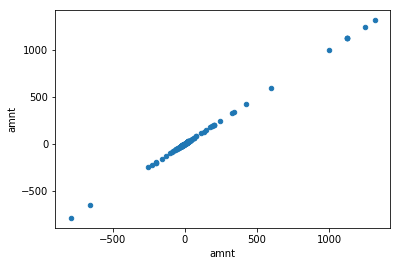

In [30]:
df.plot.scatter(x='amnt', y='amnt')

In [31]:
df.loc[df['From'] == 'Lauren Malone']

#all of laurens non-rent transfers to me, for debt or otherwise, are below 1100 dollars, so set a cutoff there and exclude
#all transfers from Lauren above that limit, this avoids including rent payments in the final in-n-out tracker
#the tracker already assumes she's paid that.
i1 = df['From'] == 'Lauren Malone'
i2 = df['amnt'] > 1100

i = i1&i2

df_no_big_lauren = df.loc[~i]

In [32]:
df.sort_values(by='Datetime')

,Datetime,Note,From,To,amnt
63,2018-07-06 19:37:45,Saladang,Andy Halleran,Reed McCardell,13.00
64,2018-07-06 20:15:34,Lunch at the Garden,John Marken,Reed McCardell,13.00
65,2018-07-06 20:16:04,Saladang,Rory Williams,Reed McCardell,13.00
66,2018-07-06 20:16:49,🥘,Leah Keiser,Reed McCardell,15.00
67,2018-08-27 16:56:59,For being such a kewl dud,Emanuel Flores,Reed McCardell,50.00
128,2018-09-04 20:30:03,🏕,Lauren Malone,Reed McCardell,-45.00
129,2018-09-07 20:33:18,Thai food,Sanjana Kulkarni,Reed McCardell,13.00
130,2018-09-07 20:34:04,Pizza,James Parkin,Reed McCardell,17.55
131,2018-09-07 20:34:06,Saladang,Rory Williams,Reed McCardell,20.15
132,2018-09-07 20:35:04,Thai food,Jan Gregrowicz,Reed McCardell,18.85


In [33]:
df.to_csv(directory + 'venmo_full_hist.csv')

df_no_big_lauren.to_csv(directory + 'venmo_nobigLauren_hist.csv')

In [34]:
df.resample('M', on='Datetime').sum().to_csv(directory + 'venmo_monthly_hist.csv')
df_no_big_lauren.resample('M', on='Datetime').sum().to_csv(directory + 'venmo_nobigLauren_monthly_hist.csv')